<a href="https://colab.research.google.com/github/prashanth018/Text-Summarization/blob/Dyuthi/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import io
import re
import spacy
from time import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving news_category_dataset-161000-171000.csv to news_category_dataset-161000-171000 (1).csv


In [ ]:
dataset = pd.read_csv(io.BytesIO(uploaded[r'news_category_dataset-161000-171000.csv']))
dataset

,Unnamed: 0,news_text,category,headline,short_desc,url
0,1,This undated publicity film image provided by ...,ENTERTAINMENT,Entertainment vs. Historical Accuracy?,A filmmaker who seeks to portray major events ...,https://www.huffingtonpost.com/entry/entertain...
1,2,"WASHINGTON, UNITED STATES: The Easter Bunny wa...",ENTERTAINMENT,The Easter Bunny And 11 Other Famous Rabbits I...,"March 31 marks Easter Sunday, and with it come...",https://www.huffingtonpost.com/entry/the-easte...
2,3,1 / 712 Animal Photos Of The Week (9/16-9/22)\...,ENVIRONMENT,"Animal Photos Of The Week: Lemurs, Lions, Monk...",Here’s a recap of animal stories and events fr...,https://www.huffingtonpost.com/entry/animal-ph...
3,4,* Melted ice re-freezes faster than sea water ...,ENVIRONMENT,Antarctica Melting Brings Expanded Sea Ice Ext...,"WINDS At a winter maximum in September, ice on...",https://www.huffingtonpost.com/entry/antarctic...
4,5,Co-written by Pushker Kharecha and Makiko Sato...,ENVIRONMENT,Doubling Down on Our Faustian Bargain,Humanity's Faustian climate bargain is well kn...,https://www.huffingtonpost.com/entry/doubling-...
...,...,...,...,...,...,...
9995,9996,Last week I shared how I was able to get off c...,WELLNESS,Change Is Easy... When You Want It,Before you start making lofty resolutions that...,https://www.huffingtonpost.com/entry/new-year-...
9996,9997,"""It is not true that money can't buy happiness...",WELLNESS,10 Tricks to Avoid Utter Misery This Holiday S...,Be happy with what you have instead of allowin...,https://www.huffingtonpost.com/entry/holiday-s...
9997,9998,"Even if you don't, there's no need to be afrai...",FOOD & DRINK,5 Seriously Spicy Cocktails,Do you love hot sauce? Sriracha? Chile peppers...,https://www.huffingtonpost.com/entry/spicy-coc...
9998,9999,After stumbling across this peculiar Check You...,HOME & LIVING,11 Most Inappropriate Christmas Ornaments We'v...,"This might be almost NSFW thanks to ""pornaments.""",https://www.huffingtonpost.com/entry/inappropr...


In [ ]:
dataset = dataset[0:2000]
dataset

,Unnamed: 0,news_text,category,headline,short_desc,url
0,1,This undated publicity film image provided by ...,ENTERTAINMENT,Entertainment vs. Historical Accuracy?,A filmmaker who seeks to portray major events ...,https://www.huffingtonpost.com/entry/entertain...
1,2,"WASHINGTON, UNITED STATES: The Easter Bunny wa...",ENTERTAINMENT,The Easter Bunny And 11 Other Famous Rabbits I...,"March 31 marks Easter Sunday, and with it come...",https://www.huffingtonpost.com/entry/the-easte...
2,3,1 / 712 Animal Photos Of The Week (9/16-9/22)\...,ENVIRONMENT,"Animal Photos Of The Week: Lemurs, Lions, Monk...",Here’s a recap of animal stories and events fr...,https://www.huffingtonpost.com/entry/animal-ph...
3,4,* Melted ice re-freezes faster than sea water ...,ENVIRONMENT,Antarctica Melting Brings Expanded Sea Ice Ext...,"WINDS At a winter maximum in September, ice on...",https://www.huffingtonpost.com/entry/antarctic...
4,5,Co-written by Pushker Kharecha and Makiko Sato...,ENVIRONMENT,Doubling Down on Our Faustian Bargain,Humanity's Faustian climate bargain is well kn...,https://www.huffingtonpost.com/entry/doubling-...
...,...,...,...,...,...,...
1995,1996,FILE - This undated performance photo shows Ji...,ENTERTAINMENT,"Jimi Hendrix's 'People, Hell and Angels': Post...","For more, head over to Billboard. ""People, Hel...",https://www.huffingtonpost.com/entry/jimi-hend...
1996,1997,"GLASTONBURY, ENGLAND - JUNE 24: Wu Tang Clan p...",ENTERTAINMENT,New Wu-Tang Clan: Cappadonna Says The Group Wi...,The album was also confirmed earlier this mont...,https://www.huffingtonpost.com/entry/new-wu-ta...
1997,1998,March 10 (Reuters) - The California wildlife s...,ENVIRONMENT,Cat Haven Preserve To Reopen To Public After L...,A four-year-old male lion named Cous Cous esca...,https://www.huffingtonpost.com/entry/cat-have-...
1998,1999,1 / 712 Animal Photos Of The Week (9/16-9/22)\...,ENVIRONMENT,"Animal Photos Of The Week: Tapirs, Monkeys, Ba...",Check out the newest and best animal photos be...,https://www.huffingtonpost.com/entry/animal-ph...


In [ ]:
df = pd.DataFrame()
df['news_text'] = dataset['news_text']
df['headline'] = dataset['headline']
df

,news_text,headline
0,This undated publicity film image provided by ...,Entertainment vs. Historical Accuracy?
1,"WASHINGTON, UNITED STATES: The Easter Bunny wa...",The Easter Bunny And 11 Other Famous Rabbits I...
2,1 / 712 Animal Photos Of The Week (9/16-9/22)\...,"Animal Photos Of The Week: Lemurs, Lions, Monk..."
3,* Melted ice re-freezes faster than sea water ...,Antarctica Melting Brings Expanded Sea Ice Ext...
4,Co-written by Pushker Kharecha and Makiko Sato...,Doubling Down on Our Faustian Bargain
...,...,...
1995,FILE - This undated performance photo shows Ji...,"Jimi Hendrix's 'People, Hell and Angels': Post..."
1996,"GLASTONBURY, ENGLAND - JUNE 24: Wu Tang Clan p...",New Wu-Tang Clan: Cappadonna Says The Group Wi...
1997,March 10 (Reuters) - The California wildlife s...,Cat Haven Preserve To Reopen To Public After L...
1998,1 / 712 Animal Photos Of The Week (9/16-9/22)\...,"Animal Photos Of The Week: Tapirs, Monkeys, Ba..."


In [ ]:
def text_strip(column):

    for row in column:
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        yield row

In [ ]:
processed_text = text_strip(df['news_text'])
processed_summary = text_strip(df['headline'])
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=5000)]
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=5000)]

In [ ]:
df['cleaned_news_text'] = pd.Series(text)
df['cleaned_headline'] = pd.Series(summary)

In [ ]:
df

,news_text,headline,cleaned_news_text,cleaned_headline
0,This undated publicity film image provided by ...,Entertainment vs. Historical Accuracy?,this undated publicity film image provided by ...,_START_ entertainment vs historical accuracy ...
1,"WASHINGTON, UNITED STATES: The Easter Bunny wa...",The Easter Bunny And 11 Other Famous Rabbits I...,washington united states the easter bunny wave...,_START_ the easter bunny and 11 other famous r...
2,1 / 712 Animal Photos Of The Week (9/16-9/22)\...,"Animal Photos Of The Week: Lemurs, Lions, Monk...",1 712 animal photos of the week 9/16-9/22 yant...,_START_ animal photos of the week lemurs lions...
3,* Melted ice re-freezes faster than sea water ...,Antarctica Melting Brings Expanded Sea Ice Ext...,melted ice re-freezes faster than sea water i...,_START_ antarctica melting brings expanded sea...
4,Co-written by Pushker Kharecha and Makiko Sato...,Doubling Down on Our Faustian Bargain,co-written by pushker kharecha and makiko sato...,_START_ doubling down on our faustian bargain ...
...,...,...,...,...
1995,FILE - This undated performance photo shows Ji...,"Jimi Hendrix's 'People, Hell and Angels': Post...",file this undated performance photo shows jimi...,_START_ jimi hendrix people hell and angels po...
1996,"GLASTONBURY, ENGLAND - JUNE 24: Wu Tang Clan p...",New Wu-Tang Clan: Cappadonna Says The Group Wi...,glastonbury england june 24 wu tang clan perfo...,_START_ new wu-tang clan cappadonna says the g...
1997,March 10 (Reuters) - The California wildlife s...,Cat Haven Preserve To Reopen To Public After L...,march 10 reuters the california wildlife sanct...,_START_ cat haven preserve to reopen to public...
1998,1 / 712 Animal Photos Of The Week (9/16-9/22)\...,"Animal Photos Of The Week: Tapirs, Monkeys, Ba...",1 712 animal photos of the week 9/16-9/22 yant...,_START_ animal photos of the week tapirs monke...


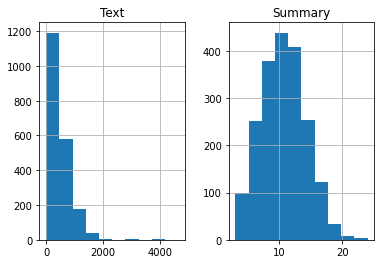

In [ ]:
text_count = []
summary_count = []
for sent in df['cleaned_news_text']:
  text_count.append(len(sent.split()))
for sent in df['cleaned_headline']:
  summary_count.append(len(sent.split()))
graph = pd.DataFrame()
graph['Text'] = text_count
graph['Summary'] = summary_count
graph.hist(bins=10)
plt.show()

In [ ]:
cnt = 0
for sent in df['cleaned_news_text']:
  if len(sent.split())<=1500:
    cnt=cnt+1
print(cnt/len(df['cleaned_news_text']))

0.979


In [ ]:
max_text_len = 1500
max_summary_len = 50

In [ ]:
cleaned_text = np.array(df['cleaned_news_text'])
cleaned_summary= np.array(df['cleaned_headline'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})

post_pre.head(2)

,text,summary
0,this undated publicity film image provided by ...,_START_ entertainment vs historical accuracy ...
1,washington united states the easter bunny wave...,_START_ the easter bunny and 11 other famous r...


In [ ]:
post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x \
        + ' eostok')

post_pre.head(2)

,text,summary
0,this undated publicity film image provided by ...,sostok _START_ entertainment vs historical acc...
1,washington united states the easter bunny wave...,sostok _START_ the easter bunny and 11 other f...


In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_pre["text"]),
    np.array(post_pre["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [ ]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  68.31037622250287


In [ ]:
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 10791


In [ ]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 89.33700570529214
Size of vocabulary in Y = 543


In [ ]:
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [ ]:
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [ ]:
latent_dim = 120
embedding_dim = 70

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 70)     755370      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 1500, 120),  91680       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=30,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/30
14/14 [==============================] - 218s 15s/step - loss: 4.2632 - val_loss: 0.9717
Epoch 2/30
14/14 [==============================] - 207s 15s/step - loss: 0.9629 - val_loss: 0.8292
Epoch 3/30
14/14 [==============================] - 209s 15s/step - loss: 0.8466 - val_loss: 0.7729
Epoch 4/30
14/14 [==============================] - 214s 15s/step - loss: 0.8148 - val_loss: 0.7527
Epoch 5/30
14/14 [==============================] - 210s 15s/step - loss: 0.7801 - val_loss: 0.7014
Epoch 6/30
14/14 [==============================] - 211s 15s/step - loss: 0.7259 - val_loss: 0.6674
Epoch 7/30
14/14 [==============================] - 209s 15s/step - loss: 0.7121 - val_loss: 0.6474
Epoch 8/30
14/14 [==============================] - 208s 15s/step - loss: 0.6851 - val_loss: 0.6376
Epoch 9/30
14/14 [==============================] - 207s 15s/step - loss: 0.6715 - val_loss: 0.6187
Epoch 10/30
14/14 [==============================] - 204s 15s/step - loss: 0.6566 - val_loss: 0.6089

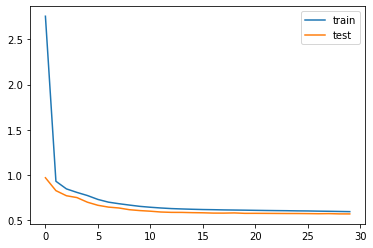

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [ ]:
for i in range(0, 19):
    print('Review:', seq2text(x_tr[i]))
    print('Original summary:', seq2summary(y_tr[i]))
    print('Predicted summary:', decode_sequence(x_tr[i].reshape(1,
           max_text_len)))
    print('\n')

Review: being in this band for the past 12 years has been true blessing statement posted to the band website reads we ve gotten to go places we never knew we would we ve been able to see and experience things we never imagined possible we ve shared the stage with people we admire people we look up to and best of all our friends and now like all great things it has come time for it to end thanks for all of your support and for being part of the adventure 
Original summary: start my as thanks for end 
Predicted summary:  start the to the end


Review: couples who married in 2012 spent about 28 000 on average on their weddings but that doesn mean you have to do the same we asked top wedding experts for their budget saving advice and they responded with tips and tricks that will lower your spending without your vision check out the slideshow below to discover steps you can take at every step of the planning process to save money after all no one wants to start their marriage in debt 
Origi